<a href="https://colab.research.google.com/github/srikarraju/eGrocery_Demand_Prediction/blob/main/Reinforce_LSTM_egrocery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorboardX

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import random
import pandas as pd
from tensorboardX import SummaryWriter

In [ ]:
class EGroceryEnv():

	def __init__(self, df=pd.DataFrame({0:[0]}), products_count=10, features=['a'], shelf_life=[1], wastage_cost=[1], shortage_cost=[1]):
		super(EGroceryEnv, self).__init__()

		self.df = df
		self.products_count = products_count
		self.shelf_life = shelf_life
		self.features = features
		self.wastage_cost = wastage_cost
		self.shortage_cost = shortage_cost
		self.current_step = 0
		self.wastage_track = list([])
		self.shortage_track = list([])
		self.reward_track = list([])

		#variables to track shartage and wastage
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		#Define Stock
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])
		print(features)


	def _next_observation(self):

		obs  = self.df.loc[self.current_step,self.features]

		st_temp = list([])
		for i in range(len(self.stock)):
			for j in range(1,min(int(self.stock[i][0])+1,5)):
				st_temp.append(self.stock[i][j])
			if(self.stock[i][0]==5):
				st_temp.append(self.stock[i][4])
			elif(self.stock[i][0]<5):
				for j in range(int(self.stock[i][0])+1,6):
					st_temp.append(0)
			else:
				st_temp.append(np.sum(self.stock[i][5:int(self.stock[i][0])+1]))
		obs = list(obs) + list(st_temp) + list(self.shelf_life)
		return obs

	def _take_action(self, action):
		#Add products to the current stocks
		for i in range(self.products_count):
			if(len(self.stock[i])<self.shelf_life[i]):
				for j in range(len(self.stock[i]),int(self.shelf_life[i])):
					self.stock[i].append(0)
			self.stock[i].append(action[i])
			self.stock[i][0]=self.shelf_life[i]



		#Fullfill demand
		prods = ['prod'+str(i) for i in [8,11,15,17,94,95,96,110,112,128]]
		demand = self.df.loc[self.current_step+1,prods]
		for i in range(self.products_count):
			for j in range(1,int(self.stock[i][0])+1):
				if(self.stock[i][j]>=demand[i]):
					self.stock[i][j] = self.stock[i][j] - demand[i]
					demand[i] = 0
					break
				else:
					demand[i] = demand[i] - self.stock[i][j]
					self.stock[i][j] = 0
			if(demand[i]>0):
				self.shortage[i]=demand[i]

		#Update shelf life and find out wastage
		for i in range(self.products_count):
			self.stock[i][0] = self.stock[i][0] -1
			if(self.stock[i][1]>0):
				self.wastage[i] = self.stock[i][1]
			for j in range(1,int(self.stock[i][0])+1):
				self.stock[i][j] = self.stock[i][j+1]
			self.stock[i].pop()


	def step(self, action):
	        # update stock, fullfill demand and calculate shortage and wastage
		quantity = [6, 10, 15, 4, 6, 2, 7, 50, 2, 30]
		action1 = [0]*self.products_count
		for i in range(len(action)):
			action1[i] = action[i]*quantity[i]
		self._take_action(action1)
		self.action = action

		#increment step
		self.current_step += 1


		reward = -1*(np.matmul(self.wastage_cost,self.wastage.transpose())+np.matmul(self.shortage_cost,self.shortage.transpose()))
		self.reward = reward
		done = (self.current_step < 0) or (self.current_step > self.df.shape[0]-2)

		obs = self._next_observation()

		self.wastage_track.append(np.sum(self.wastage))
		self.shortage_track.append(np.sum(self.shortage))
		self.reward_track.append(np.abs(self.reward))


		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		return obs, np.sum(self.reward), done, {}

	def reset(self):
		# Reset the state of the environment to an initial state
		self.current_step = 0
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])

		#print(len(self.features),products_count)
		#print(self.features)
		return [0]*len(self.features) + [0]*6*self.products_count

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std, lr, betas):
        super(ActorCritic, self).__init__()
        # actor
        self.hidden_state = torch.Tensor(np.zeros(32, dtype=float)).unsqueeze(0)
        self.cell_state = torch.Tensor(np.zeros(32, dtype=float)).unsqueeze(0)

        self.lstm_cell = nn.LSTMCell(state_dim, hidden_size=32)

        self.linear_layer = nn.Linear(32, action_dim)
        self.relu = nn.ReLU()
        self.actor_params = list(self.lstm_cell.parameters()) + list(self.linear_layer.parameters())

        # self.actor =  nn.Sequential(
        #         nn.Linear(state_dim, 512),
        #         nn.ReLU(),
        #         nn.Linear(512, 512),
        #         nn.ReLU(),
        #         nn.Linear(512, 256),
        #         nn.ReLU(),
        #         nn.Linear(256, action_dim),
        #         nn.ReLU())
        self.action_var = torch.full((action_dim,), action_std * action_std)
        # self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, betas=betas)
        self.actor_optimizer = torch.optim.Adam(self.actor_params, lr=lr, betas=betas)
        self.MseLoss = nn.MSELoss()
        self.policy_net_loss = torch.rand(700)

    def forward(self, state):
        state = torch.Tensor(state)
        state = state.unsqueeze(0)
        (self.hidden_state, self.cell_state) = self.lstm_cell(state, (self.hidden_state, self.cell_state))
        actor_mean = self.relu(self.linear_layer(self.hidden_state))

        # action_mean = self.actor(state)
        # print(action_var)
        action_var = self.action_var.expand_as(action_mean)
        # print(action_var)
        cov_mat = torch.diag_embed(action_var)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        return action_logprobs, dist_entropy, action_mean

    def act(self, state):
        state = torch.Tensor(state)
        state = state.unsqueeze(0)
        (self.hidden_state, self.cell_state) = self.lstm_cell(state, (self.hidden_state, self.cell_state))
        action_mean = self.relu(self.linear_layer(self.hidden_state))
        # action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var)

        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        # memory.states.append(state)
        # memory.actions.append(action)
        # memory.logprobs.append(action_logprob)

        return action.detach(),action_mean

    def evaluate(self, state, action, action_mean):
        # action_mean = self.actor(state)

        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        return action_logprobs, dist_entropy

    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()

    def update(self, trajectory):
        states, actions, rewards, action_means = [], [], [], []
        log_probs = []
        for sample in trajectory:
            state, action, next_state, reward, done, action_mean = sample[0], sample[1], sample[2], sample[3], sample[4], sample[5]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            action_means.append(action_mean)

        rewards = np.array(rewards)
        R = torch.tensor([np.sum(rewards[i:] * (gamma ** np.array(range(0, len(rewards) - i)))) for i in
                          range(len(rewards))]).float()
        # states = torch.tensor(states).float()
        # actions = torch.tensor(actions)
        #action_means = torch.Tensor(action_means)

        log_probs = []
        self.policy_net_loss = torch.Tensor([0])
        for i in range(len(states)):
            state = torch.tensor(states[i]).float()
            action = torch.tensor(actions[i])
            action_logprobs, _ = self.evaluate(state, action, action_means[i])
            self.policy_net_loss += action_logprobs * R[i]

        self.policy_net_loss = -self.policy_net_loss
        #log_probs, _ = self.evaluate(states, actions, action_means)

        #self.policy_net_loss = torch.sum(log_probs * R)
        self.actor_optimizer.zero_grad()
        self.policy_net_loss.backward()
        self.actor_optimizer.step()

    def revert(self, trajectory):
        states, actions, rewards = [], [], []
        log_probs = []
        for sample in trajectory:
            state, action, next_state, reward, done = sample[0], sample[1], sample[2], sample[3], sample[4]
            states.append(state)
            actions.append(action)
            rewards.append(reward)

        rewards = np.array(rewards)
        R = torch.tensor([np.sum(rewards[i:] * (gamma ** np.array(range(0, len(rewards) - i)))) for i in
                          range(len(rewards))]).float()
        states = torch.tensor(states).float()
        actions = torch.tensor(actions)

        log_probs, _ = self.evaluate(states, actions)

        self.policy_net_loss = -torch.sum(log_probs * R)
        self.actor_optimizer.zero_grad()
        self.policy_net_loss.backward()
        self.actor_optimizer.step()

    def reset_hidden_states(self):
        self.hidden_state = torch.Tensor(np.zeros(32, dtype=float)).unsqueeze(0)
        self.cell_state = torch.Tensor(np.zeros(32, dtype=float)).unsqueeze(0)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_trainx.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_testx.csv')

products_count = 10
#products_count = 1

avg_f7 = ['prod'+str(i)+'avg7' for i in [8,11,15,17,94,95,96,110,112,128]]
avg_f15 = ['prod'+str(i)+'avg15' for i in [8,11,15,17,94,95,96,110,112,128]]
avg_f30 = ['prod'+str(i)+'avg30' for i in [8,11,15,17,94,95,96,110,112,128]]

# avg_f7 = ['prod'+str(i)+'avg7' for i in [8]]
# avg_f15 = ['prod'+str(i)+'avg15' for i in [8,]]
# avg_f30 = ['prod'+str(i)+'avg30' for i in [8,]]

features = ['month', 'monthday', 'weekday'] + avg_f7 + avg_f15 + avg_f30

print(features)

shelf_life = np.array([4, 3, 5, 10, 7, 2, 1, 3, 8, 6], dtype=np.float32)
#shelf_life = np.array([4], dtype=np.float32)

wastage_cost = np.array([1]*products_count, dtype=np.float16)
shortage_cost = np.array([1]*products_count, dtype=np.float16)

action_std = 0.5
eps_clip = 0.2
gamma = 0.99

lr = 0.0001
betas = (0.9, 0.999)
K_epochs = 5

update_timestep = 20
time_step=0
running_reward = 0

state_dim = len(features) + 6*products_count
action_dim = products_count

env = EGroceryEnv(df_train, products_count, features, shelf_life, wastage_cost, shortage_cost)

#ac = ActorCritic(state_dim, action_dim, action_std,lr ,betas)

writer = SummaryWriter()

Total_reward = []


['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']
['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']


In [ ]:
policy = ActorCritic(state_dim, action_dim, action_std, lr, betas)
gamma = 0.99

In [ ]:
n_episode = 1
returns = []

while n_episode <=50000:
  rewards,states,actions = [],[],[]
  action_means = []
  state = env.reset()
  policy.reset_hidden_states()
  trajectory = []
  while True:
    #_, _, action_mean = policy.forward(torch.tensor(state).float())
    action,action_mean = policy.act(torch.tensor(state).float())
    action = torch.squeeze(action,0)

    new_state, reward, done, info = env.step(action)
    #action = action.tolist()

    states.append(state)
    actions.append(action)
    rewards.append(reward)
    action_means.append(action_mean)
    trajectory.append((state,action,new_state,reward,done,action_mean))

    state = new_state
    if done==True:
      break

  policy.update(trajectory)

  if n_episode!= 1 and abs(np.sum(rewards)-returns[len(returns)-1]) >100000:
    policy.revert(trajectory)
    break
  returns.append(np.sum(rewards))
  print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.sum(rewards)))
  n_episode += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode:      1	Avg. Return: -203709.00
Episode:      2	Avg. Return: -201702.00
Episode:      3	Avg. Return: -204458.00
Episode:      4	Avg. Return: -205002.00
Episode:      5	Avg. Return: -204003.00
Episode:      6	Avg. Return: -203801.00
Episode:      7	Avg. Return: -202199.00
Episode:      8	Avg. Return: -203075.00
Episode:      9	Avg. Return: -202001.00
Episode:     10	Avg. Return: -202848.00
Episode:     11	Avg. Return: -202362.00
Episode:     12	Avg. Return: -202782.00
Episode:     13	Avg. Return: -201322.00
Episode:     14	Avg. Return: -201054.00
Episode:     15	Avg. Return: -202331.00
Episode:     16	Avg. Return: -202714.00
Episode:     17	Avg. Return: -203189.00
Episode:     18	Avg. Return: -202872.00
Episode:     19	Avg. Return: -202094.00
Episode:     20	Avg. Return: -203040.00
Episode:     21	Avg. Return: -203041.00
Episode:     22	Avg. Return: -201644.00
Episode:     23	Avg. Return: -202428.00
Episode:     24	Avg. Return: -202689.00
Episode:     25	Avg. Return: -201979.00


In [ ]:
env2 = EGroceryEnv(df_test, products_count, features, shelf_life, wastage_cost, shortage_cost)
state = env2.reset()
actions_test = []
for step in range(0,30):
  #print("state:",state)
  state = np.asarray(state,dtype=float)
  action,_ = policy.act(state)
  actions_test.append(action.item())
  next_state,reward,done,_ = env2.step(action)
  #print(reward)
  state = next_state
print(env2.reward_track)
print(actions_test)
print(df_test['prod8'])

NameError: ignored

In [ ]:
import pandas as pd
import numpy as np

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_testx.csv')
cols = ['prod'+str(i) for i in [8,11,15,17,94,95,96,110,112,128]]
shelf_life = np.array([4, 3, 5, 10, 7, 2, 1, 3, 8, 6])
wastages = []
j = 0

for i in range(31):
  wastage = 0
  j = 0
  for col in cols:
    wastage += (int(df_test[col][i])%shelf_life[j])
    j +=1
  wastages.append(wastage)


print(wastages)

[0, 21, 13, 16, 25, 10, 16, 21, 15, 20, 15, 24, 17, 21, 14, 12, 15, 13, 7, 14, 19, 14, 19, 14, 16, 22, 21, 14, 17, 8, 20]


In [ ]:
[-5.0, -2.0, -3.0, -3.0, -3.0, -49.0, -40.0, -12.0, -45.0, -2.0, -1.0, -4.0, 0.0, 0.0, 0.0, -37.0, -30.0, -29.0, -17.0, -23.0, -21.0, -3.0, -6.0, -9.0, -8.0, -10.0, -4.0, -16.0, -11.0, -25.0]

In [ ]:
print(sum(wastages))

493


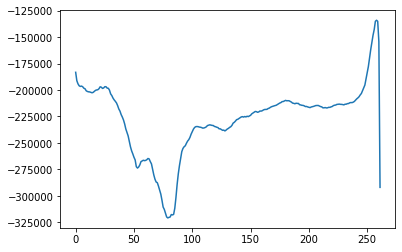

In [ ]:
from matplotlib import pyplot as plt


plt.plot(returns[0:len(returns)-1])
plt.show()

In [ ]:
print(sum(env2.reward_track)/len(env2.reward_track))
print(env2.wastage_track)
print(env2.shortage_track)

196.36666666666667
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[323, 230, 198, 146, 186, 232, 134, 261, 215, 121, 125, 216, 187, 174, 154, 231, 205, 187, 206, 203, 219, 168, 195, 118, 156, 191, 226, 268, 203, 213]


10753 6700 7567 5891


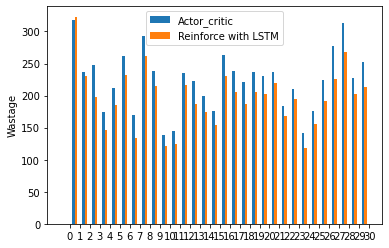

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 31
DQN_wastage = (0,41,5,191,295,357,279,642,468,583,483,449,485,498,233,344,439,404,470,250,289,246,426,493,295,293,384,270,483,313,345)
Actor_critic = (0,318,237,247,175,212,262,170,293,239,138,145,235,222,199,176,263,238,221,236,231,236,183,211,142,176,225,278,313,227,252)
PPO = (0,324,275,267,200,238,294,195,320,275,164,180,261,247,235,212,290,268,240,272,250,266,227,242,175,210,254,302,335,266,283)
Reinforce = (0,323, 230, 198, 146, 186, 232, 134, 261, 215, 121, 125, 216, 187, 174, 154, 231, 205, 187, 206, 203, 219, 168, 195, 118, 156, 191, 226, 268, 203, 213)

DQN_wastage2 = [0,41,5,191,295,357,279,642,468,583,483,449,485,498,233,344,439,404,470,250,289,246,426,493,295,293,384,270,483,313,345]
Actor_critic2 = [0,318,237,247,175,212,262,170,293,239,138,145,235,222,199,176,263,238,221,236,231,236,183,211,142,176,225,278,313,227,252]
PPO2 = [0,324,275,267,200,238,294,195,320,275,164,180,261,247,235,212,290,268,240,272,250,266,227,242,175,210,254,302,335,266,283]
Reinforce2 = [0,323, 230, 198, 146, 186, 232, 134, 261, 215, 121, 125, 216, 187, 174, 154, 231, 205, 187, 206, 203, 219, 168, 195, 118, 156, 191, 226, 268, 203, 213]

print(sum(DQN_wastage2),sum(Actor_critic2),sum(PPO2),sum(Reinforce2))

ind = np.arange(N)
ind = 2*ind
width = 0.5
# plt.bar( ind,DQN_wastage, width, label='DQN')
# plt.bar(ind + width, PPO, width,label='PPO')
#plt.bar(ind + width + width, Actor_critic, width,label='Actor_critic')
#plt.bar(ind + 3*width, Reinforce, width,label='Reinforce')


plt.bar(ind, Actor_critic, width,label='Actor_critic')
plt.bar(ind + width, Reinforce, width,label='Reinforce with LSTM')


plt.ylabel('Wastage')
#plt.title('Scores by group and gender')

plt.xticks(ind + 5*width / 2, np.arange(N))
plt.legend(loc='best')
plt.savefig('Shortage.png')